In [2]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import matplotlib.animation as animation

In [3]:
f = 857e12     # Frequency input to determine cell width
nmax = 10      # Maximum optical density
imax = 400     # Number of cells in x-direction
jmax = 400     # Number of cells in y-direction
radius = 40    # Schawrzschild radius of BH
zrange  = np.linspace(0,1,imax)
eps0 = 8.854187812813e-12    # Permittivity of free space
mu0 = 1.2566370621219e-6     # Permeability of free space
c0 = round(1/np.sqrt(mu0*eps0))   # Speed of light in free space
deltax = c0/(10*f*nmax)      # Cell width in x-direction
deltay = c0/(10*f*nmax)      # Cell width in y-direction
deltat = deltax/(2*c0)       # Size of a single time-step
tprop = imax*2               # Number of time-steps for wave to propagate across full domain in free space
T = int(np.ceil(5*len(zrange) + 10*tprop))  # Total number of time-steps - Enough time for full source injection and several propagations across domain
tau = 50          # Standard deviation(width) of Gaussian source
t0 = tau*2        # Time of peak intensity of Gaussian source
isource = 30 #imax/2 #round(imax/4)
jsource = 30 #127*2 #round(jmax/6)
MatCenti = int(imax/2)     # Central point of material x-axis
MatCentj = int(jmax/2)     # Central point of material y-axis
A = 2   # Relative strength of source

#PML thickness coefficients
Lxmax = 20*deltax     # Width of PML
Lymax = 20*deltay

MatFileName = 'SchwarzschildBH2_400_40.csv'   # File name of the material
PMLFileName = 'PML400_40.csv'   # File name of the PML

In [4]:
# Import material permittivity from file
df = pd.read_csv(MatFileName)
Material = df.to_numpy()
Material = np.delete(Material,0,1)  # Delete extra column created by pandas dataframe

Materialxx = Material[:imax,:]           # Break single array into each component
Materialxy = Material[imax:imax*2,:]
Materialyx = Material[imax*2:imax*3,:]
Materialyy = Material[imax*3:imax*4,:]
Materialzz = Material[imax*4:,:]

Materialxz = np.zeros((imax,jmax))
Materialzx = np.zeros((imax,jmax))
Materialyz = np.zeros((imax,jmax))
Materialzy = np.zeros((imax,jmax))

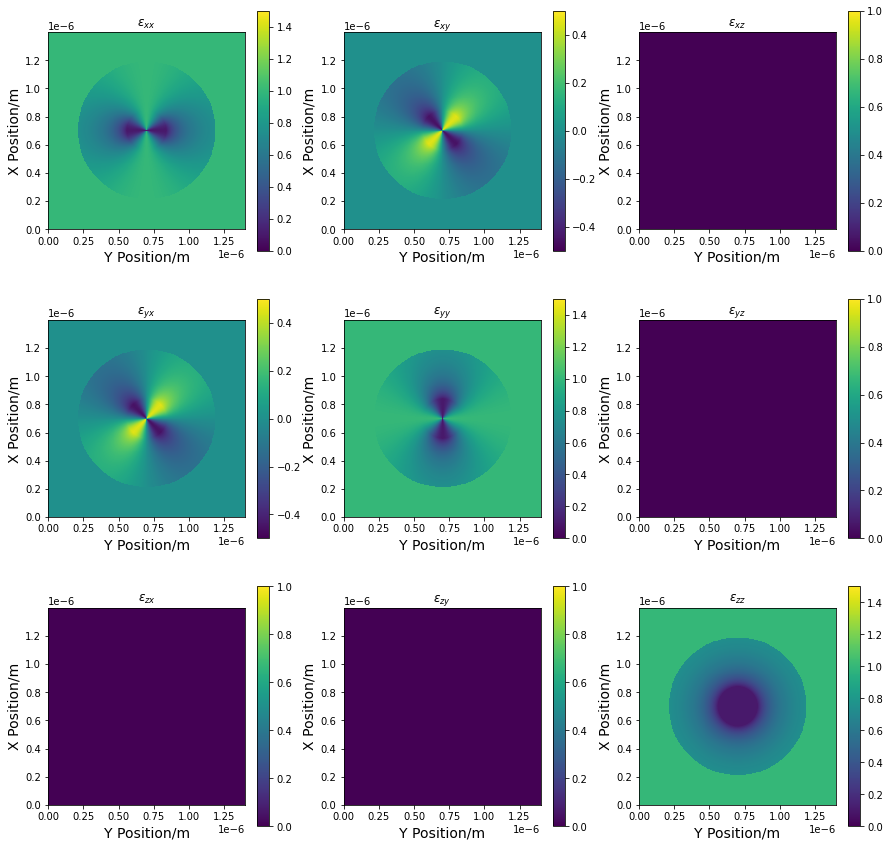

In [6]:
# Plot permittivity matrix
plt.rcParams["figure.figsize"] = 15,15
fig, ax = plt.subplots(3,3)

ax[0,0].set_title('$\epsilon_{xx}$')
ax[0,1].set_title('$\epsilon_{xy}$')
ax[0,2].set_title('$\epsilon_{xz}$')
ax[1,0].set_title('$\epsilon_{yx}$')
ax[1,1].set_title('$\epsilon_{yy}$')
ax[1,2].set_title('$\epsilon_{yz}$')
ax[2,0].set_title('$\epsilon_{zx}$')
ax[2,1].set_title('$\epsilon_{zy}$')
ax[2,2].set_title('$\epsilon_{zz}$')
xx = ax[0,0].imshow(Materialxx, interpolation='none', vmin = 0, vmax = 1.5, aspect=1, origin='lower', extent=(0,imax*deltax,0,jmax*deltay))
fig.colorbar(xx, ax=ax[0,0])
xy = ax[0,1].imshow(Materialxy, interpolation='none', vmin = -0.5, vmax = 0.5, aspect=1, origin='lower', extent=(0,imax*deltax,0,jmax*deltay))
fig.colorbar(xy, ax = ax[0,1])
xz = ax[0,2].imshow(Materialxz, interpolation='none', vmin = 0, vmax = 1, aspect=1, origin='lower', extent=(0,imax*deltax,0,jmax*deltay))
fig.colorbar(xz, ax = ax[0,2])
yx = ax[1,0].imshow(Materialyx, interpolation='none', vmin = -0.5, vmax = 0.5, aspect=1, origin='lower', extent=(0,imax*deltax,0,jmax*deltay))
fig.colorbar(yx, ax = ax[1,0])
yy = ax[1,1].imshow(Materialyy, interpolation='none', vmin = 0, vmax = 1.5, aspect=1, origin='lower', extent=(0,imax*deltax,0,jmax*deltay))
fig.colorbar(yy, ax = ax[1,1])
yz = ax[1,2].imshow(Materialyz, interpolation='none', vmin = 0, vmax = 1, aspect=1, origin='lower', extent=(0,imax*deltax,0,jmax*deltay))
fig.colorbar(yz, ax = ax[1,2])
zx = ax[2,0].imshow(Materialzx, interpolation='none', vmin = 0, vmax = 1, aspect=1, origin='lower', extent=(0,imax*deltax,0,jmax*deltay))
fig.colorbar(zx, ax = ax[2,0])
zy = ax[2,1].imshow(Materialzy, interpolation='none', vmin = 0, vmax = 1, aspect=1, origin='lower', extent=(0,imax*deltax,0,jmax*deltay))
fig.colorbar(zy, ax = ax[2,1])
zz = ax[2,2].imshow(Materialzz, interpolation='none', vmin = 0, vmax = 1.5, aspect=1, origin='lower', extent=(0,imax*deltax,0,jmax*deltay))
fig.colorbar(zz, ax = ax[2,2])

for row in range(3):
    for col in range(3):
        ax[row,col].set_xlabel('Y Position/m',fontsize=14)
        ax[row,col].set_ylabel('X Position/m',fontsize=14)
#fig.savefig('D:/adjel/Documents/Y4 Project/Report/images/BH2/SchwarzschildPermittivity.png')
plt.show()

In [5]:
# Import PML from file
df = pd.read_csv(PMLFileName)
PML = df.to_numpy()
PML = np.delete(PML,0,1)   # Delete extra column created by pandas dataframe

sxBx = PML[:imax,:]             # Split array into each conductivity component
sxBy = PML[imax:imax*2,:]
syBx = PML[imax*2:imax*3,:]
syBy = PML[imax*3:imax*4,:]
sxDz = PML[imax*4:imax*5,:]
syDz = PML[imax*5:,:]

In [6]:
# # Cover inner region with constant conductivity
# for i in range(imax):
#     for j in range(jmax):
#         if (i-MatCenti)**2+(j-MatCentj)**2<(radius)**2:
#             sxBx[i,j] = 0.2
#             sxBy[i,j] = 0.2
#             syBx[i,j] = 0.2
#             syBy[i,j] = 0.2
#             sxDz[i,j] = 0.2
#             syDz[i,j] = 0.2

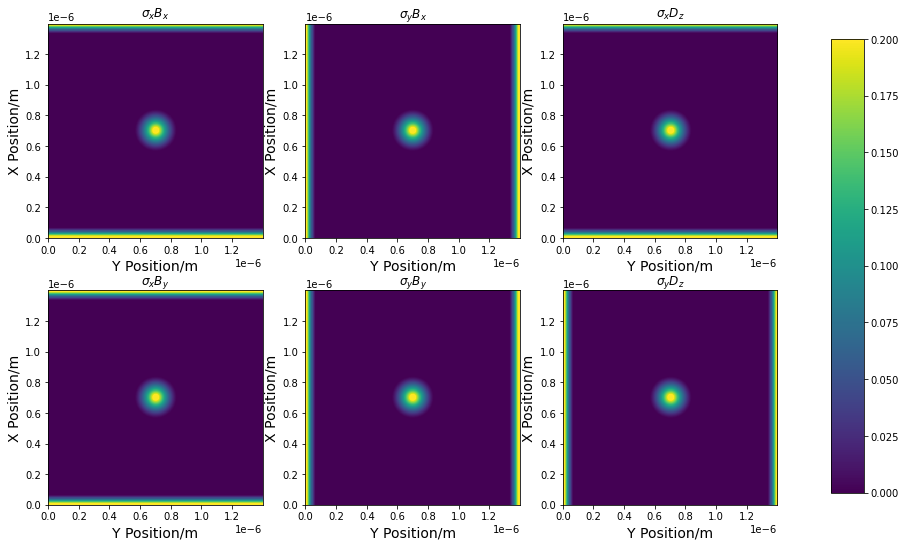

In [7]:
# Plot PML
plt.rcParams["figure.figsize"] = 15, 9
fig, ax = plt.subplots(2,3)
ax[0,0].set_title('$\sigma_{x}B_x$')
ax[1,0].set_title('$\sigma_{x}B_y$')
ax[0,1].set_title('$\sigma_{y}B_x$')
ax[1,1].set_title('$\sigma_{y}B_y$')
ax[0,2].set_title('$\sigma_{x}D_z$')
ax[1,2].set_title('$\sigma_{y}D_z$')
im = ax[0,0].imshow(sxBx, interpolation='none', aspect=1, origin='lower',vmin=0,vmax=0.2, extent=(0,imax*deltax,0,jmax*deltay))
ax[1,0].imshow(sxBy, interpolation='none', aspect=1, origin='lower',vmin=0,vmax=0.2, extent=(0,imax*deltax,0,jmax*deltay))
ax[0,1].imshow(syBx, interpolation='none', aspect=1, origin='lower',vmin=0,vmax=0.2, extent=(0,imax*deltax,0,jmax*deltay))
ax[1,1].imshow(syBy, interpolation='none', aspect=1, origin='lower',vmin=0,vmax=0.2, extent=(0,imax*deltax,0,jmax*deltay))
ax[0,2].imshow(sxDz, interpolation='none', aspect=1, origin='lower',vmin=0,vmax=0.2, extent=(0,imax*deltax,0,jmax*deltay))
ax[1,2].imshow(syDz, interpolation='none', aspect=1, origin='lower',vmin=0,vmax=0.2, extent=(0,imax*deltax,0,jmax*deltay))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax)
for row in range(2):
    for col in range(3):
        ax[row,col].set_xlabel('Y Position/m',fontsize=14)
        ax[row,col].set_ylabel('X Position/m',fontsize=14)
plt.show()

In [8]:
# PML coefficients for update equations
BxK1 = (1-syBx)/(1+syBx)
BxK2 = -0.5*(1/(1+syBx))
BxK3 = -sxBx/(1+syBx)
ByK1 = (1-sxBy)/(1+sxBy)
ByK2 = 0.5*(1/(1+sxBy))
ByK3 = syBy/(1+sxBy)
DzK1 = (1-sxDz-syDz-sxDz*syDz)/((1+sxDz)*(1+syDz))
DzK2 = 0.5/((1+sxDz)*(1+syDz))
DzK3 = -4*sxDz*syDz/((1+sxDz)*(1+syDz))

In [9]:
# Source function
def g(t):
    return A*np.exp(-((t-t0)/(tau))**2)

In [13]:
# Use either this cell or the below cell to define update function to choose a source type
# Function carries out update equations, injects source and handles boundaries
# Regular source
def update(t):
    
    global Ezo
    global Bxo
    global Byo
    global Dzo
    global CurlExSum
    global CurlEySum
    global DzSum
    
    Ezo2 = np.c_[Ezo,np.zeros(jmax)]      # Shifts cells for update equation (Ez[i,j+1]-Ez[i,j])  - Allows vectorization to be used
    Ezo2 = Ezo2[:,1:]
    Ezo3 = np.vstack([Ezo,np.zeros(imax)])   # Shifts cells for update equation (Ez[i+1,j]-Ez[i,j])
    Ezo3 = Ezo3[1:,:]
    
    CurlEx = np.subtract(Ezo2,Ezo)    
    CurlEy = np.subtract(Ezo3,Ezo)
    
    CurlEx[int(imax/8):imax-int(imax/8),int(jmax/10)] -= g(t)   # One way source moving in y-direction
    
    CurlExSum += CurlEx
    CurlEySum += CurlEy


    
    Bx = np.add(BxK1*Bxo,np.add(BxK2*CurlEx,BxK3*CurlExSum))     # Update B-field
    By = np.add(ByK1*Byo,np.add(ByK2*CurlEy,ByK3*CurlEySum))
    
    Hx = np.add(np.multiply(Bx,Materialxx),np.multiply(By,Materialxy))    # Update H-field
    Hy = np.add(np.multiply(By,Materialyy),np.multiply(Bx,Materialyx))   
    
    Hx2 = np.c_[np.zeros(jmax),Hx]          # Shifts cells for update equation (Hx[i,j]-Hx[i,j-1])
    Hx2 = Hx2[:,:jmax]
    Hy2 = np.vstack([np.zeros(imax),Hy])    # Shift cells for update equation (Hy[i,j]-Hy[i-1,j])
    Hy2 = Hy2[:imax,:]

    CurlHz = np.subtract(np.subtract(Hy,Hy2),np.subtract(Hx,Hx2))
    
    CurlHz[int(imax/8):imax-int(imax/8),int(jmax/10)] += g(t)   # One way source moving in y-direction
    
    DzSum += Dzo
    
    Dz = np.add(np.add(DzK1*Dzo,DzK2*CurlHz),DzK3*DzSum)    # Update D-field

    #Dz[int(jmax/6),int(imax/6)] = g(t)   # Hard point source
    
    Ez = np.multiply(Dz,Materialzz)     # Update E-field
    
    Bxo = Bx     # Assign 'old' variables for use in next iteration
    Byo = By
    Ezo = Ez
    Dzo = Dz
    
    if t%10 == 0:
        label.set_text(f'time step: {t}')  # Update time step for plot
        im.set_array(Dz)      # Update new field for plot

In [10]:
# # Function carries out update equations, injects source and handles boundaries
# # Sinusoidal source on photon sphere
# def update(t):
    
#     global Ezo
#     global Bxo
#     global Byo
#     global Dzo
#     global CurlExSum
#     global CurlEySum
#     global DzSum
    
#     gt = 50*np.sin(t/10)   # Separate source created for sinusoidal plot
    
#     Ezo2 = np.c_[Ezo,np.zeros(jmax)]
#     Ezo2 = Ezo2[:,1:]
#     Ezo3 = np.vstack([Ezo,np.zeros(imax)])
#     Ezo3 = Ezo3[1:,:]
    
#     CurlEx = np.subtract(Ezo2,Ezo)
#     CurlEy = np.subtract(Ezo3,Ezo)
    
#     CurlExSum += CurlEx
#     CurlEySum += CurlEy
    
#     Bx = np.add(BxK1*Bxo,np.add(BxK2*CurlEx,BxK3*CurlExSum))
#     By = np.add(ByK1*Byo,np.add(ByK2*CurlEy,ByK3*CurlEySum))
    
#     Hx = np.add(np.multiply(Bx,Materialxx),np.multiply(By,Materialxy))
#     Hy = np.add(np.multiply(By,Materialyy),np.multiply(Bx,Materialyx))   
    
#     Hx2 = np.c_[np.zeros(jmax),Hx]
#     Hx2 = Hx2[:,:jmax]
#     Hy2 = np.vstack([np.zeros(imax),Hy])
#     Hy2 = Hy2[:imax,:]

#     CurlHz = np.subtract(np.subtract(Hy,Hy2),np.subtract(Hx,Hx2))
    
#     DzSum += Dzo
    
#     Dz = np.add(np.add(DzK1*Dzo,DzK2*CurlHz),DzK3*DzSum)    

#     Dz[int(imax/2),int(imax/2+radius*1.5)] = gt
    
#     Ez = np.multiply(Dz,Materialzz)
    
#     Bxo = Bx
#     Byo = By
#     Ezo = Ez
#     Dzo = Dz
#     if t%10 == 0:
#         label.set_text(f'time step: {t}')  # Update time step for plot
#         im.set_array(Dz)      # Update new field for plot

<IPython.core.display.Javascript object>


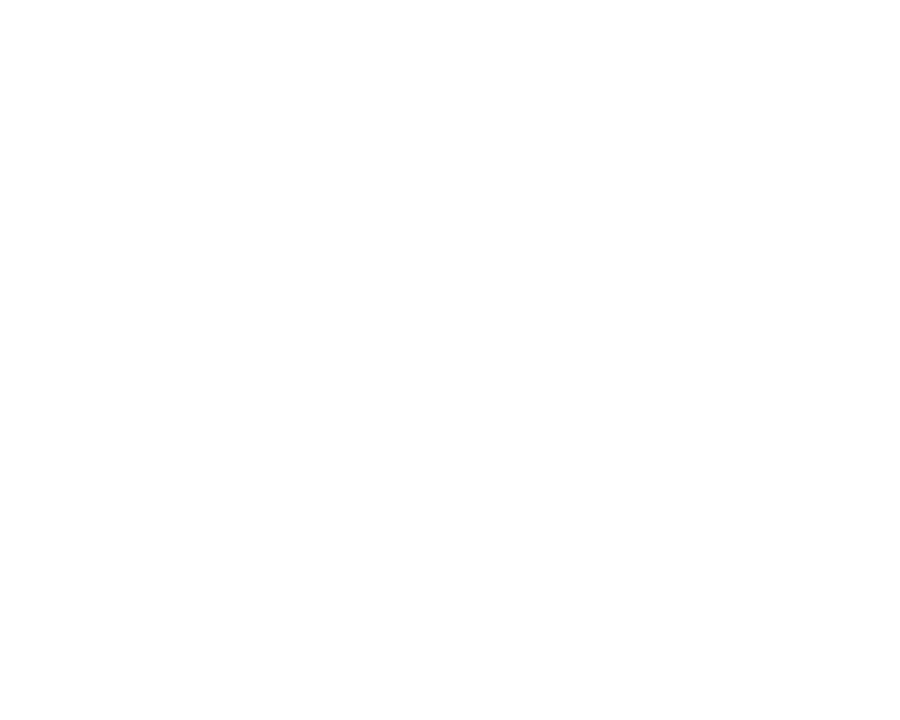

In [11]:
#Plot evolution of field
%matplotlib notebook

Bxo = np.zeros((imax,jmax))    # Initialise variables
Byo = np.zeros((imax,jmax))
Ezo = np.zeros((imax,jmax))
Dzo = np.zeros((imax,jmax))
CurlExSum = np.zeros((imax,jmax))
CurlEySum = np.zeros((imax,jmax))
DzSum = np.zeros((imax,jmax))
Dz = np.zeros((imax,jmax))

plt.rcParams["figure.figsize"] = 10,8
fig, ax = plt.subplots()

label = ax.text((jmax*0.8)*deltay, (imax+2)*deltax, "0", fontsize=16)
rectangle = plt.Rectangle((Lxmax,Lxmax),imax*deltax-2*Lxmax,jmax*deltay-2*Lymax,fc = 'none',ec = 'white')   # Create and add patches to show where BH region is, Schwarzschild radius, and photon sphere
circle = plt.Circle(((imax*deltax)/2,(jmax*deltay)/2),(radius)*deltax,fc = 'none',ec = 'white')
circle2 = plt.Circle(((imax*deltax)/2,(jmax*deltay)/2),radius=(radius)*deltax*3.5,fc = 'none',ec = 'white')
circle3 = plt.Circle(((imax*deltax)/2,(jmax*deltay)/2),(radius)*deltax*1.5,fc = 'none',ec = 'white',linestyle="dashed")
ax.add_patch(rectangle)
ax.add_patch(circle)
ax.add_patch(circle2)
ax.add_patch(circle3)

ax.set_xlabel('Y Position/m',fontsize=14)
ax.set_ylabel('X Position/m',fontsize=14)
im = ax.imshow(Dz,vmin = -1,vmax = 1,interpolation = 'none',aspect='auto', origin='lower', extent=(0,imax*deltax,0,jmax*deltay))

ani = animation.FuncAnimation(fig, update, frames = 5000,interval=100,repeat=False)   # Carry out animation - frames is number of iterations through update func, interval is delay between plot updating in ms
plt.colorbar(im)

plt.show()
